In [1]:
using AtomsIO
using ComponentArrays
using DftFunctionals
using JSON3
using DataFrames
using Statistics
using CairoMakie
using ColorSchemes

## A priori: Varying parameters in PBE exchange enhancement factor

In [2]:
pbe_x_f(s, θ) = 1 + θ.κ - θ.κ^2 / (θ.κ + θ.μ * s^2)

pbe_x_f (generic function with 1 method)

In [3]:
pbe_variants = [
    :gga_x_pbe,
    :gga_x_pbe_r,
    :gga_x_xpbe,
    :gga_x_pbe_sol,
    :gga_x_apbe,
    :gga_x_pbe_mol,
    :gga_x_pbefe,
]
params = Dict(
    key=>parameters(DftFunctional(key)) for key in pbe_variants
)

Dict{Symbol, ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(κ = 1, μ = 2)}}}} with 7 entries:
  :gga_x_apbe    => (κ = 0.804, μ = 0.26)
  :gga_x_xpbe    => (κ = 0.91954, μ = 0.23214)
  :gga_x_pbe     => (κ = 0.804, μ = 0.219515)
  :gga_x_pbefe   => (κ = 0.437, μ = 0.346)
  :gga_x_pbe_r   => (κ = 1.245, μ = 0.219515)
  :gga_x_pbe_sol => (κ = 0.804, μ = 0.123457)
  :gga_x_pbe_mol => (κ = 0.804, μ = 0.27583)

In [4]:
θ_pbe = params[:gga_x_pbe]

ComponentVector{Float64}(κ = 0.804, μ = 0.21951497276451704)

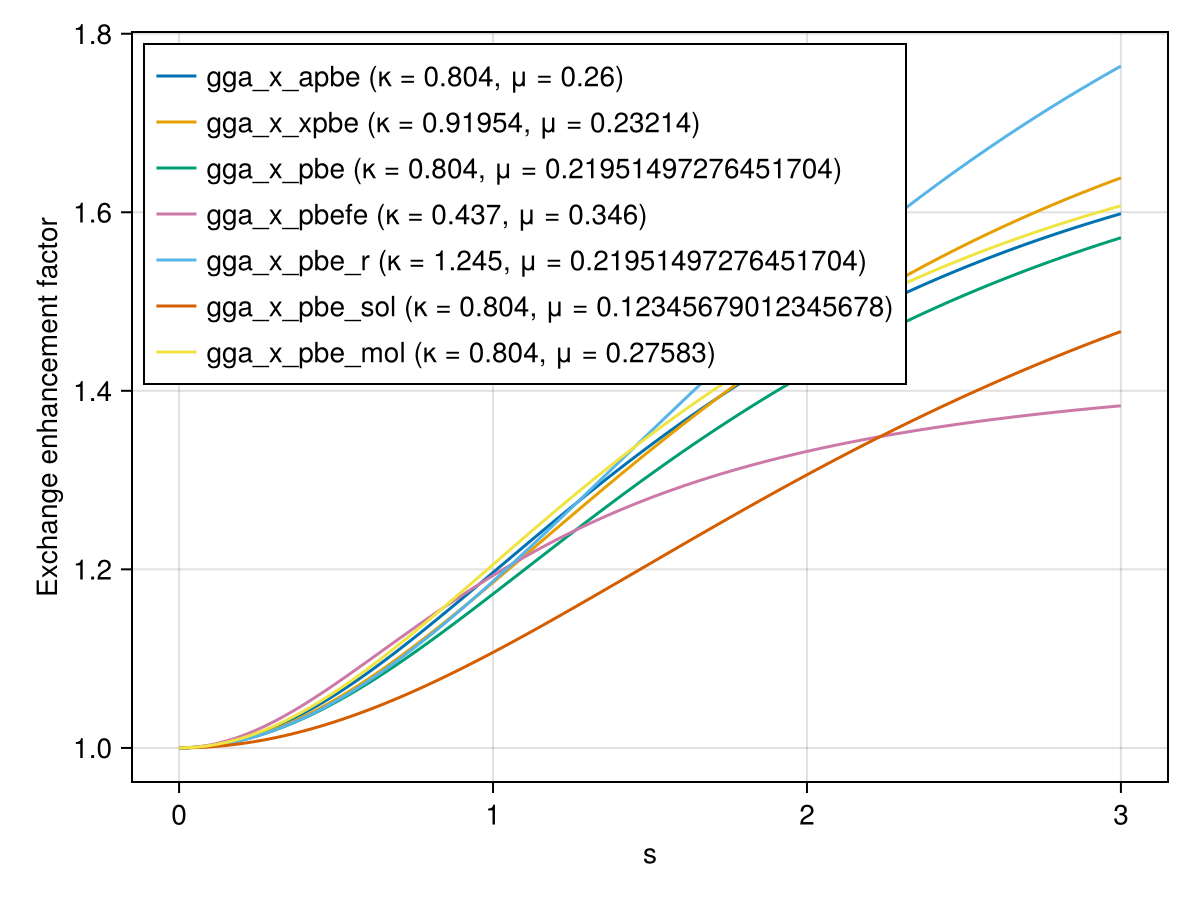

In [5]:
let fig = Figure()
    ax = Makie.Axis(fig[1, 1], xlabel="s", ylabel="Exchange enhancement factor")
    s = range(0, 3, length=100)
    for (key, θ) in pairs(params)
        lines!(ax, s, pbe_x_f.(s, Ref(θ)), label="$key $θ")
    end
    axislegend(ax, position=:lt)
    fig
end

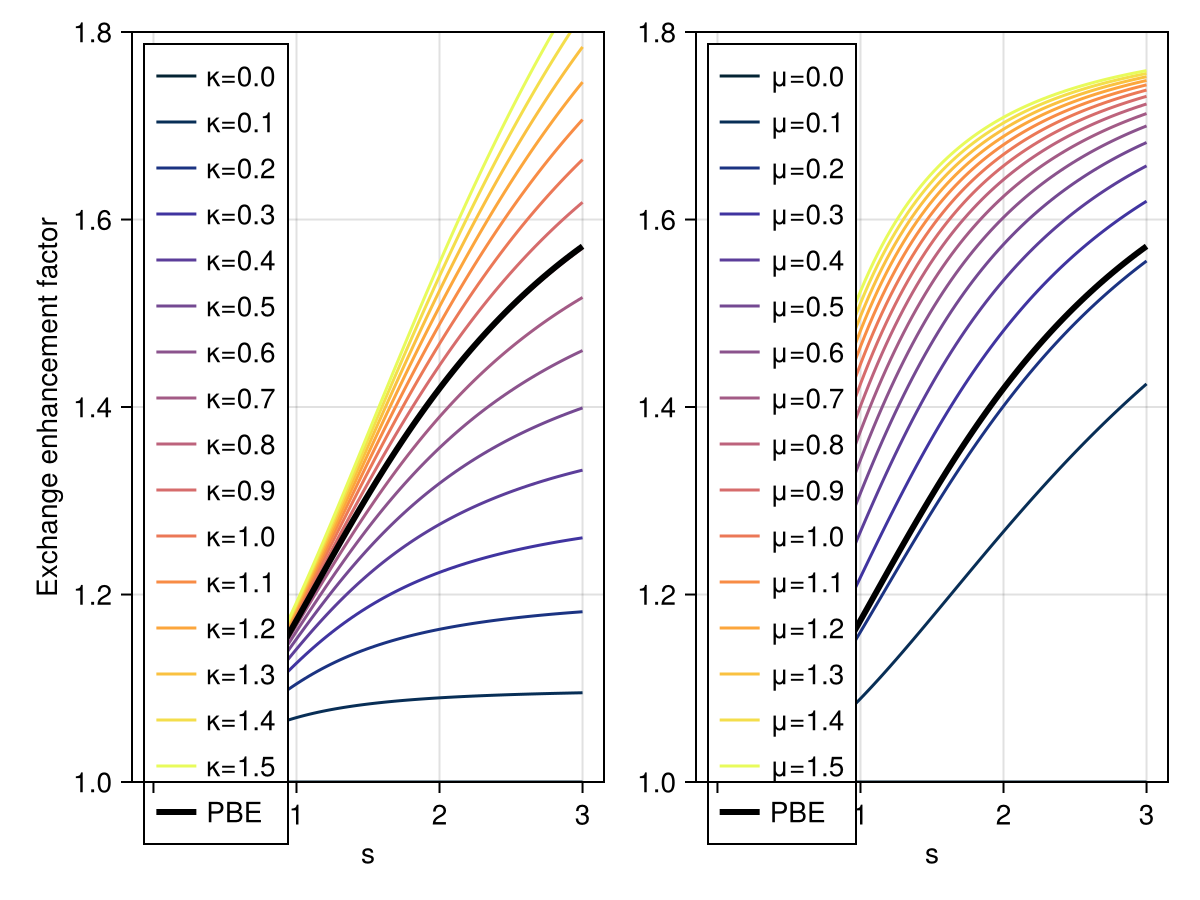

In [6]:
let κ_range = range(0., 1.5, step=0.1)
    μ_range = range(0., 1.5, step=0.1)
    
    colorscheme = ColorSchemes.colorschemes[:thermal]

    fig = Figure()
    ax = Makie.Axis(fig[1, 1], xlabel="s", ylabel="Exchange enhancement factor")
    ylims!(ax, (1.0, 1.8))
    s = range(0, 3, length=100)


    cmap = cgrad(colorscheme, length(κ_range), categorical = true)

    for (i, κ) in enumerate(κ_range)
        θ = ComponentVector(; κ, μ=θ_pbe.μ)
        lines!(ax, s, pbe_x_f.(s, Ref(θ)), color=cmap[i], label="κ=$κ")
    end
    lines!(ax, s, pbe_x_f.(s, Ref(θ_pbe)), label="PBE", color=:black, linewidth=3)
    axislegend(ax, position=:lt)
    
    ax = Makie.Axis(fig[1, 2], xlabel="s")
    ylims!(ax, (1.0, 1.8))
    cmap = cgrad(colorscheme, length(μ_range), categorical = true)
    for (i, μ) in enumerate(μ_range)
        θ = ComponentVector(; κ=θ_pbe.κ, μ)
        lines!(ax, s, pbe_x_f.(s, Ref(θ)), color=cmap[i], label="μ=$μ")
    end
    lines!(ax, s, pbe_x_f.(s, Ref(θ_pbe)), label="PBE", color=:black, linewidth=3)
    axislegend(ax, position=:lt)

    fig
end

## Correlation 

In the original PBE paper, $\mu$ was chosen from $\beta$ as $\mu = \beta (\pi^2/3)$ to satify Eq 12 (i.e. s -> 0 limit to recover the linear response limit of LSD, cancellation of effective gradient coefficient)

In [7]:
pbe_variants

7-element Vector{Symbol}:
 :gga_x_pbe
 :gga_x_pbe_r
 :gga_x_xpbe
 :gga_x_pbe_sol
 :gga_x_apbe
 :gga_x_pbe_mol
 :gga_x_pbefe

In [8]:
for key in ["pbe", "xpbe", "pbe_sol", "apbe", "pbe_mol", "pbefe"]
    gga_x = parameters(DftFunctional(Symbol("gga_x_$key")))
    gga_c = parameters(DftFunctional(Symbol("gga_c_$key")))
    @show key 
    println(gga_x.μ)
    println(DftFunctionals.pbe_μ_from_β(gga_c.β))
    println(gga_c.β)
    println(DftFunctionals.pbe_β_from_μ(gga_x.μ))
end

key = "pbe"
0.21951497276451704
0.21951497276451704
0.06672455060314922
0.06672455060314922
key = "xpbe"
0.23214
0.2954597672191447
0.089809
0.07056209871219687
key = "pbe_sol"
0.12345679012345678
0.15133393415003682
0.046
0.03752636431197695
key = "apbe"
0.26
0.26
0.07903052324102347
0.07903052324102347
key = "pbe_mol"
0.27583
0.2758225443291106
0.08384
0.0838422662521981
key = "pbefe"
0.346
0.14146432974894746
0.043
0.1051713886207466


As one can see, this relation holds for some (PBE, apbe, pbe_mol) but not for others (PBEsol, pbefe). PBEsol was a conscious departure from this, break that exact condition.

## Experimental lattice constants

In [9]:
include(joinpath(@__DIR__, "../../sol58lc/load.jl"))

# Load training set
data_path = joinpath(@__DIR__, "../../sol58lc/structures")
trainset = [
    "Si_diamond",
    # "GaAs_b3",
    "NaCl_b1",
    "Al_fcc",
    "V_bcc",
]
files_train = ["$x.extxyz" for x in trainset]
x_train = map(files_train) do file
    path = joinpath(data_path, file)
    system = load_system(path)
    convert_system_to_case(system)
end
a0_exp = Dict(case().name => case().a0_exp for case in x_train)

Dict{String, Float64} with 4 entries:
  "Al"   => 7.59481
  "NaCl" => 10.5163
  "Si"   => 10.2461
  "V"    => 5.71453

## Grid search results

In [10]:
runs = [
    # "grid_search_results_20250512_154139",
    # "grid_search_results_20250513_144244",
    # "grid_search_results_20250513_144351",
    # "grid_search_results_20250514_095948",
    # "grid_search_results_20250514_111830",
    "grid_search_results_20250515_145905",
    "grid_search_results_20250516_111755",
    "grid_search_results_20250516_111848",
]
files = reduce(vcat, [readdir(joinpath(@__DIR__, x); join=true) for x in runs])
files = filter(endswith(".json"), files)
df = DataFrame()
for f in files
    data = only(JSON3.read(f))
    if haskey(data, "loss")
        push!(df, (; theta=Vector{Float64}(data["theta"]), loss=data["loss"], preds=Dict{Symbol,Float64}(data["preds"])))
    end
end
df

Row,theta,loss,preds
,Array…,Float64,Dict…
1,"[0.1, 0.1]",0.000737347,"Dict(:NaCl=>10.1228, :Al=>7.54429, :V=>5.49443, :Si=>10.1986)"
2,"[0.1, 0.2]",0.000801281,"Dict(:NaCl=>10.0929, :Al=>7.5845, :V=>5.48781, :Si=>10.2174)"
3,"[0.1, 0.3]",0.000900357,"Dict(:NaCl=>10.0631, :Al=>7.62474, :V=>5.47731, :Si=>10.2231)"
4,"[0.1, 0.4]",0.00100133,"Dict(:NaCl=>10.038, :Al=>7.65333, :V=>5.46727, :Si=>10.2232)"
5,"[0.1, 0.5]",0.00109705,"Dict(:NaCl=>10.0171, :Al=>7.67628, :V=>5.45813, :Si=>10.2205)"
6,"[0.1, 0.6]",0.00118596,"Dict(:NaCl=>9.99938, :Al=>7.69524, :V=>5.44992, :Si=>10.2163)"
7,"[0.1, 0.7]",0.00126692,"Dict(:NaCl=>9.98422, :Al=>7.71059, :V=>5.44265, :Si=>10.2113)"
8,"[0.1, 0.8]",0.00134028,"Dict(:NaCl=>9.97105, :Al=>7.72283, :V=>5.43615, :Si=>10.206)"
9,"[0.1, 0.9]",0.00140666,"Dict(:NaCl=>9.95947, :Al=>7.73243, :V=>5.43025, :Si=>10.2006)"


In [11]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Any,Any,Union…,Any,Int64,DataType
1,theta,"[0.504167, 0.504167]","[0.0, 0.1]",,"[1.0, 1.0]",0,Vector{Float64}
2,loss,0.00181516,8.33806e-5,0.00114943,0.0183217,0,Float64
3,preds,,,,,0,"Dict{Symbol, Float64}"


In [12]:
[(loss, theta) for (loss, theta) in zip(df.loss, df.theta) if theta[1] == 0]

10-element Vector{Tuple{Float64, Vector{Float64}}}:
 (0.0011713028296992832, [0.0, 0.1])
 (0.0011713027914856825, [0.0, 0.2])
 (0.001171302820277271, [0.0, 0.3])
 (0.0011713029786317246, [0.0, 0.4])
 (0.0011713004834614097, [0.0, 0.5])
 (0.0011713028729353444, [0.0, 0.6])
 (0.0011713027727766974, [0.0, 0.7])
 (0.0011713029178696496, [0.0, 0.8])
 (0.0011713027729506266, [0.0, 0.9])
 (0.001171302582404068, [0.0, 1.0])

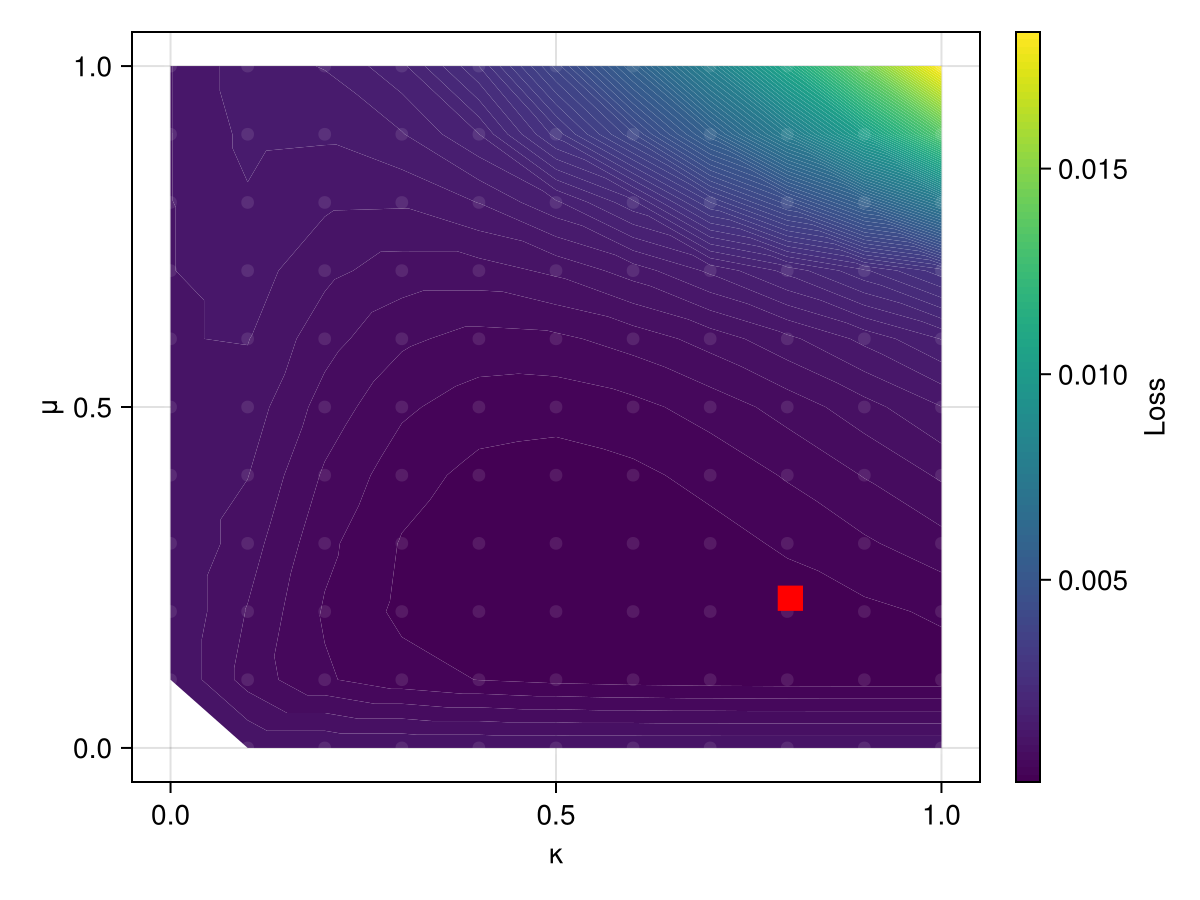

In [13]:
κ = getindex.(df.theta, 1)
μ = getindex.(df.theta, 2)
fig = Figure()
ax = Makie.Axis(fig[1,1], xlabel="κ", ylabel="μ")
co = tricontourf!(ax, κ, μ, df.loss, levels=100)
scatter!(ax, κ, μ, color=:white, alpha=0.1)
scatter!(ax, [θ_pbe.κ], [θ_pbe.μ], color=:red, marker=:rect, markersize=20)
Colorbar(fig[1,2], co, label="Loss")
fig

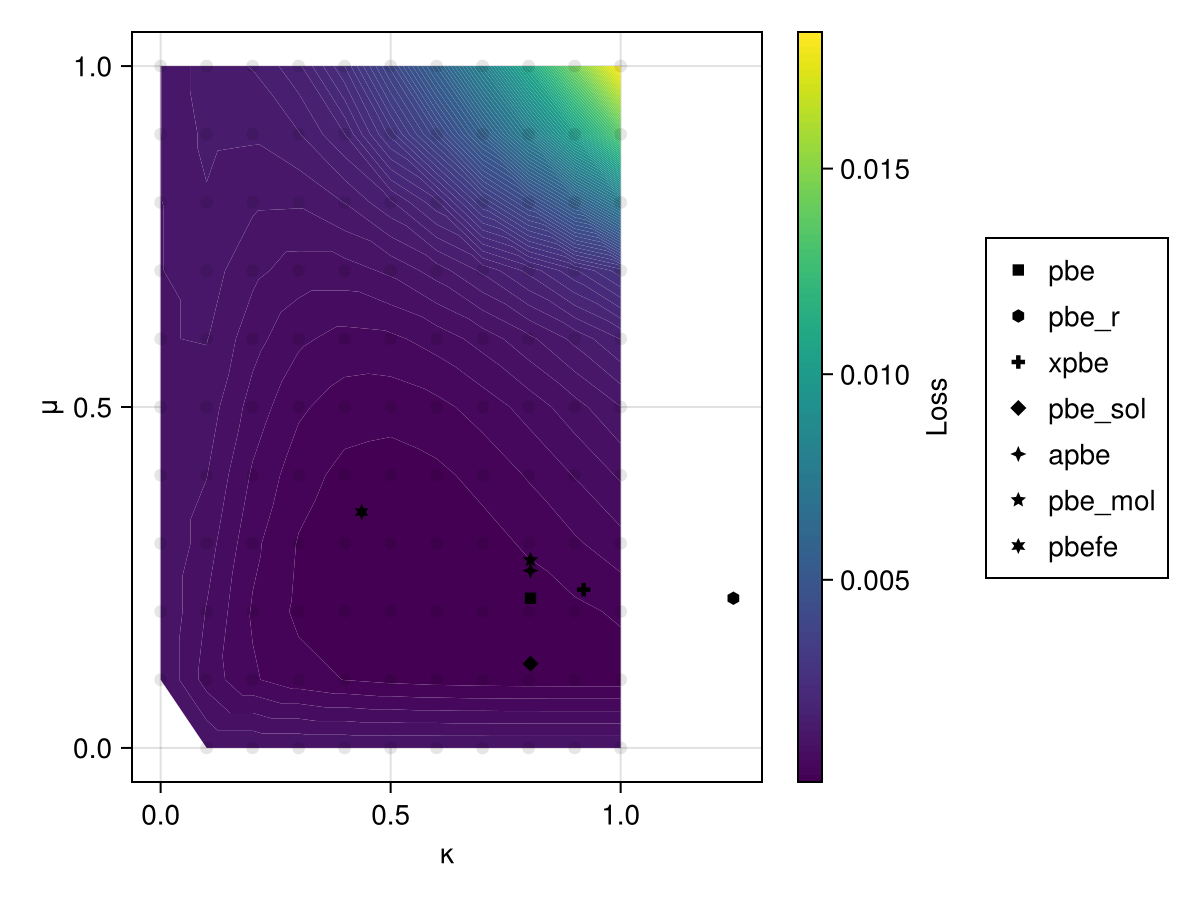

In [14]:
κ = getindex.(df.theta, 1)
μ = getindex.(df.theta, 2)
let fig = Figure()
    ax = Makie.Axis(fig[1,1], xlabel="κ", ylabel="μ")

    # limits!(ax, (0.3, 1.5), (0.1, 0.5))

    co = tricontourf!(ax, κ, μ, df.loss, levels=100)
    scatter!(ax, κ, μ, color=:black, alpha=0.1)
    markers = [
        :gga_x_pbe     => :rect,
        :gga_x_pbe_r   => :hexagon,
        :gga_x_xpbe    => :cross,
        :gga_x_pbe_sol => :diamond,
        :gga_x_apbe    => :star4,
        :gga_x_pbe_mol => :star5,
        :gga_x_pbefe   => :star6,
    ]
    for (key, marker) in markers
        θ = params[key]
        label = string(key)[7:end]
        scatter!(ax, [θ.κ], [θ.μ]; color=:black, marker, label)
    end
    Legend(fig[1,3], ax)
    Colorbar(fig[1,2], co, label="Loss")

    fig
end

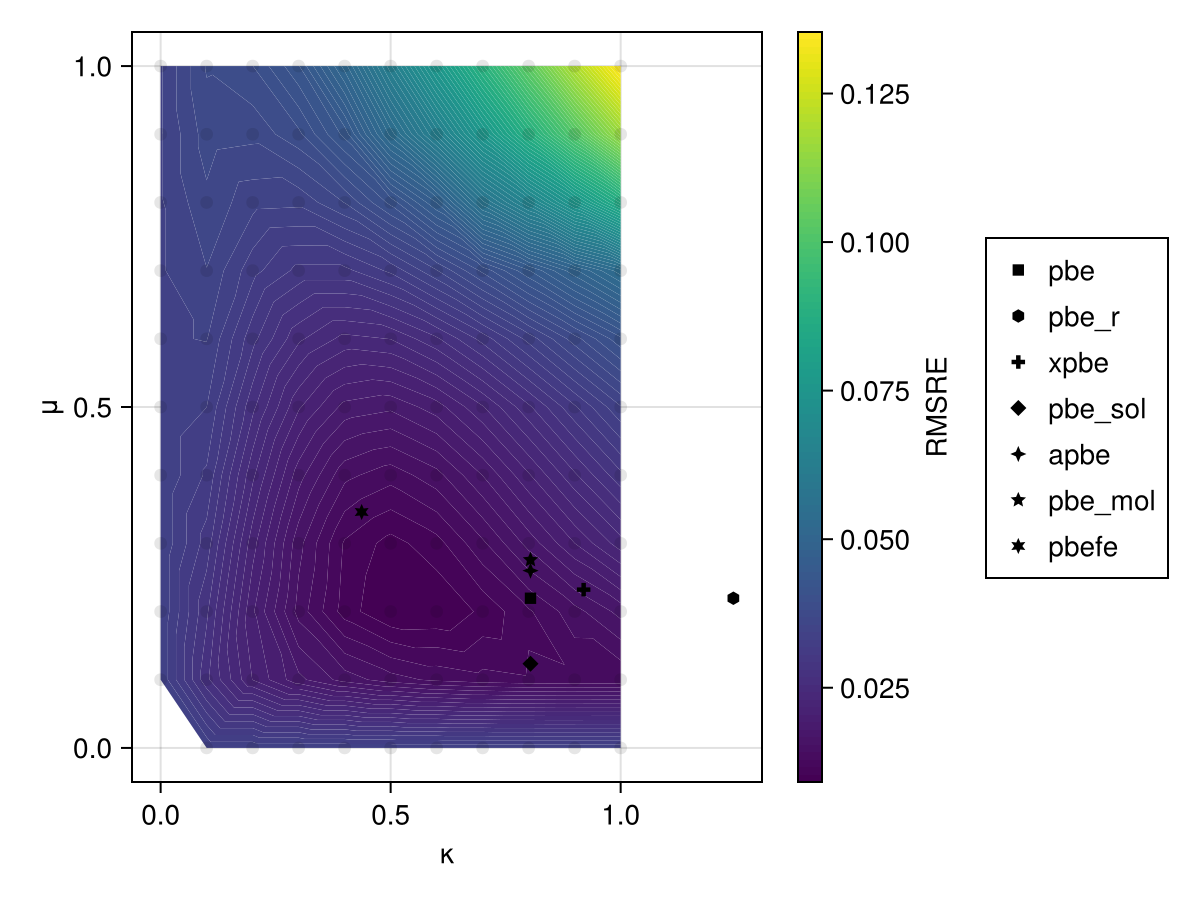

In [15]:
κ = getindex.(df.theta, 1)
μ = getindex.(df.theta, 2)
let fig = Figure()
    ax = Makie.Axis(fig[1,1], xlabel="κ", ylabel="μ")

    # limits!(ax, (0.3, 1.5), (0.1, 0.5))

    co = tricontourf!(ax, κ, μ, sqrt.(df.loss), levels=100)
    scatter!(ax, κ, μ, color=:black, alpha=0.1)
    markers = [
        :gga_x_pbe     => :rect,
        :gga_x_pbe_r   => :hexagon,
        :gga_x_xpbe    => :cross,
        :gga_x_pbe_sol => :diamond,
        :gga_x_apbe    => :star4,
        :gga_x_pbe_mol => :star5,
        :gga_x_pbefe   => :star6,
    ]
    for (key, marker) in markers
        θ = params[key]
        label = string(key)[7:end]
        scatter!(ax, [θ.κ], [θ.μ]; color=:black, marker, label)
    end
    Legend(fig[1,3], ax)
    Colorbar(fig[1,2], co, label="RMSRE")

    fig
end

## Combine plot with train trajectory

In [16]:
df_traj = let 
    file = joinpath(@__DIR__, "../pbe_Si_Al_V_NaCl/trajectory_combined.json")
    traj = JSON3.read(file)
    df = DataFrame() 
    for state in traj
        if haskey(state, "loss")
            push!(df, (; theta=Vector{Float64}(state["theta"]), loss=state["loss"], preds=Dict{Symbol,Float64}(state["preds"])))
        end
    end
    df
end

Row,theta,loss,preds
,Array…,Float64,Dict…
1,"[0.804, 0.219515]",0.000186576,"Dict(:NaCl=>10.7679, :Al=>7.6336, :V=>5.66609, :Si=>10.3354)"
2,"[0.803315, 0.218283]",0.000184584,"Dict(:NaCl=>10.7662, :Al=>7.63263, :V=>5.66522, :Si=>10.3344)"
3,"[0.803315, 0.218283]",0.000184584,"Dict(:NaCl=>10.7662, :Al=>7.63263, :V=>5.66522, :Si=>10.3344)"
4,"[0.743829, 0.111111]",0.000150801,"Dict(:NaCl=>10.5468, :Al=>7.55895, :V=>5.5778, :Si=>10.2448)"
5,"[0.743829, 0.111111]",0.000150801,"Dict(:NaCl=>10.5468, :Al=>7.55895, :V=>5.5778, :Si=>10.2448)"
6,"[0.774548, 0.167255]",0.000127078,"Dict(:NaCl=>10.6829, :Al=>7.59399, :V=>5.62665, :Si=>10.293)"
7,"[0.774548, 0.167255]",0.000127078,"Dict(:NaCl=>10.6829, :Al=>7.59399, :V=>5.62665, :Si=>10.293)"
8,"[0.766833, 0.153699]",0.000121987,"Dict(:NaCl=>10.6551, :Al=>7.58495, :V=>5.61554, :Si=>10.2816)"
9,"[0.766833, 0.153699]",0.000121987,"Dict(:NaCl=>10.6551, :Al=>7.58495, :V=>5.61554, :Si=>10.2816)"


In [17]:
# Add point at (0., 0.) which recovers LDA exchange (identical to the others with κ=0)
# We use the value from (0.0, 0.1)
κ_complete = [κ; 0.]
μ_complete = [μ; 0.]
l = df.loss[findfirst(isequal([0.0, 0.1]), df.theta)]
loss_complete = [df.loss; l]

121-element Vector{Float64}:
 0.0007373474323896208
 0.0008012812259880988
 0.0009003568946459599
 0.0010013327459217276
 0.0010970504307339759
 0.0011859601067056454
 0.0012669198197062144
 0.0013402759991904965
 0.00140665758357007
 0.0014666417928975157
 ⋮
 0.001171302820277271
 0.0011713029786317246
 0.0011713004834614097
 0.0011713028729353444
 0.0011713027727766974
 0.0011713029178696496
 0.0011713027729506266
 0.001171302582404068
 0.0011713028296992832

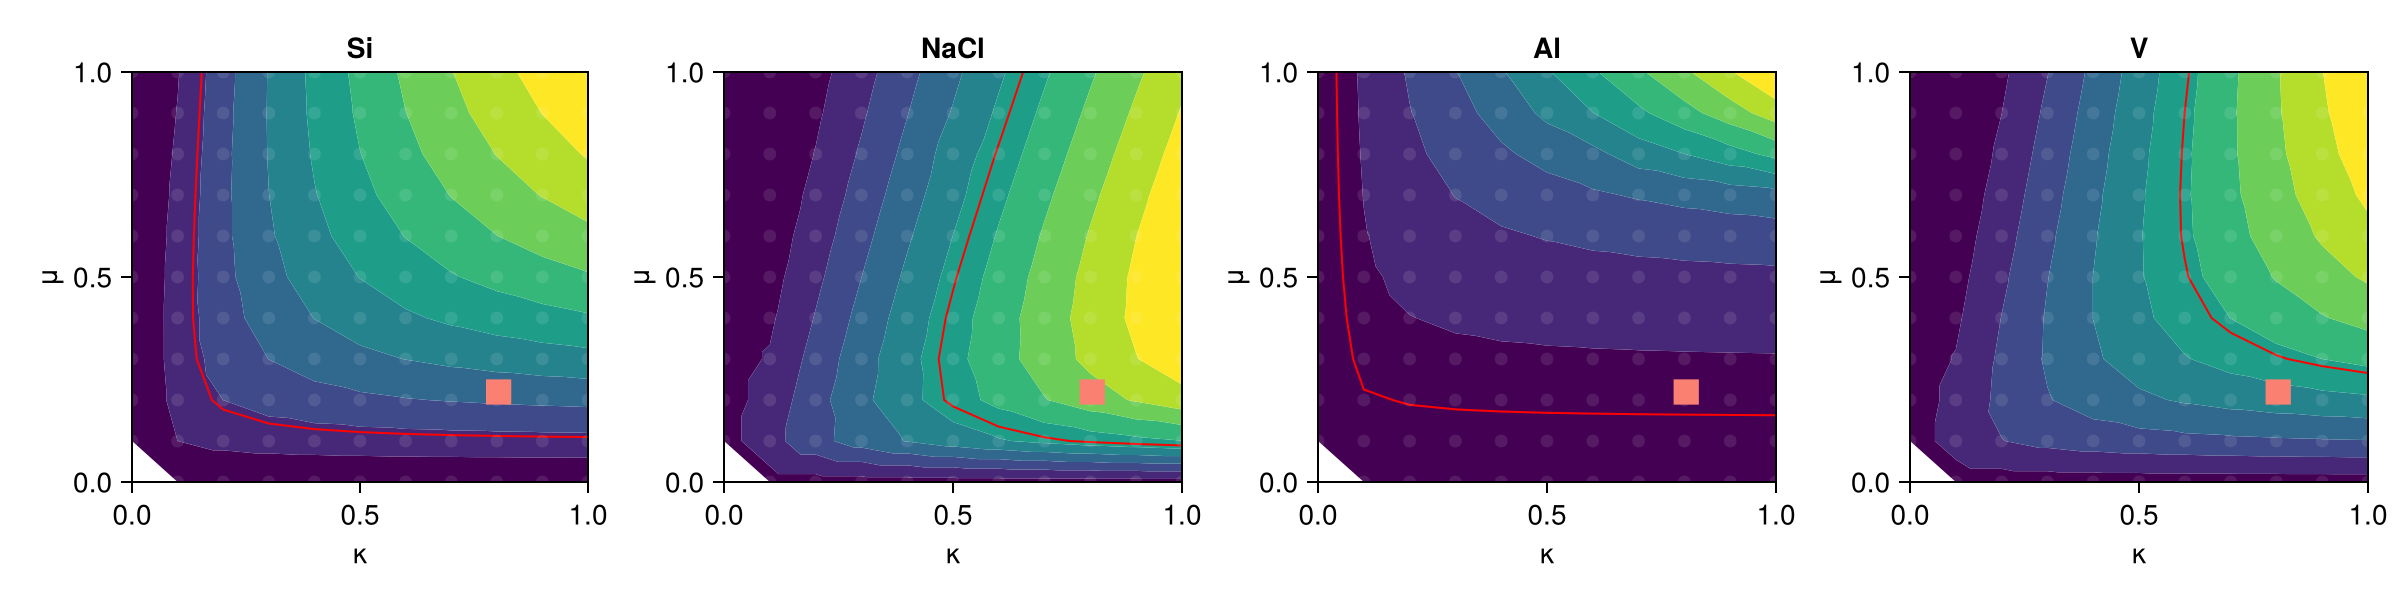

In [18]:
let fig = Figure(size=(1200,300))
    axs = Dict(
        name=>Makie.Axis(fig[1, i], xlabel="κ", ylabel="μ", title=name)
        for (i, name) in enumerate(["Si", "NaCl", "Al", "V"])
    )
    κ = getindex.(df.theta, 1)
    μ = getindex.(df.theta, 2)
    for (name, ax) in axs
        a0 = [preds[Symbol(name)] for preds in df.preds]
        tricontourf!(ax, κ, μ, a0)
        contour!(ax, κ, μ, a0, levels=[a0_exp[name]], color=:red)
        scatter!(ax, κ, μ, color=:white, alpha=0.1)
        limits!(ax, (0,1), (0,1))
        scatter!(ax, [θ_pbe.κ], [θ_pbe.μ], color=:salmon, marker=:rect, markersize=20, label="PBE")
    end
    fig
end

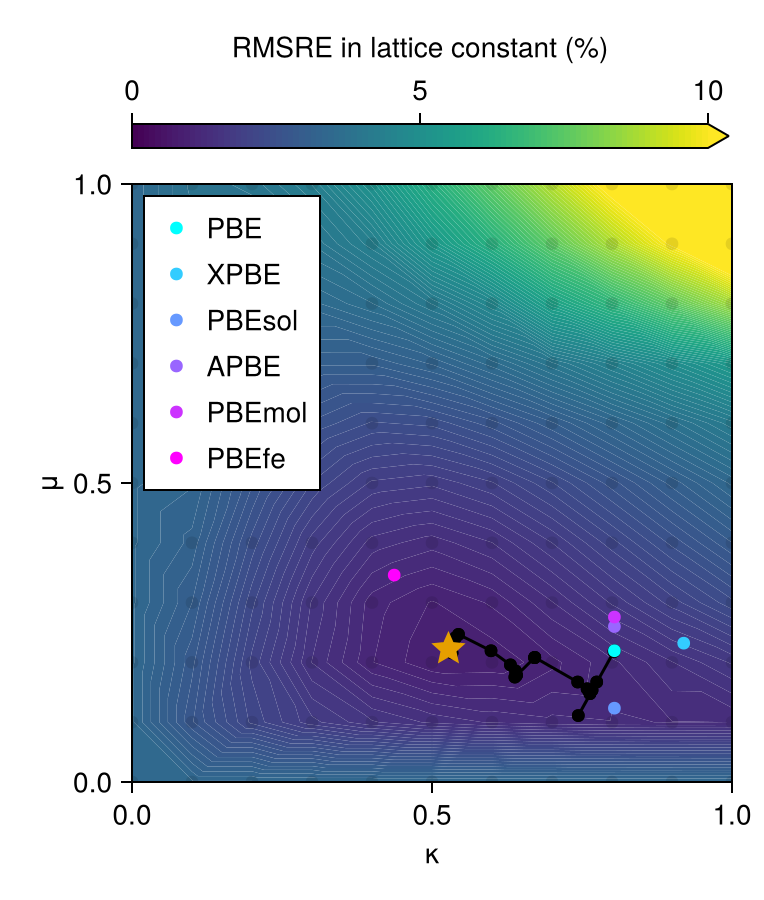

In [67]:
let fig = Figure()
    colors = Makie.wong_colors()
    ax = Makie.Axis(fig[1,1], alignmode = Inside(), xlabel="κ", ylabel="μ")
    ax.tellwidth = true
    theta = df_traj.theta

    co = tricontourf!(ax, κ_complete, μ_complete, 100sqrt.(loss_complete), levels=0:0.1:10, extendhigh=:auto)
    scatter!(ax, κ_complete, μ_complete, color=:black, alpha=0.1)

    scatterlines!(ax, getindex.(theta, 1), getindex.(theta, 2), color=:black)
    scatter!(ax, [theta[end][1]], [theta[end][2]], color=colors[2], marker=:star5, markersize=20)
    limits!(ax, (0., 1), (0., 1))

    cb = Colorbar(fig[0,1], co, label="RMSRE in lattice constant (%)", vertical=false)

    # Plot other PBE variants from the literature
    pbe_variants = [
        ("PBE",    :gga_x_pbe    ),
        # ("revPBE", :gga_x_pbe_r),
        ("XPBE",   :gga_x_xpbe   ),
        ("PBEsol", :gga_x_pbe_sol),
        ("APBE",   :gga_x_apbe   ),
        ("PBEmol", :gga_x_pbe_mol),
        ("PBEfe",  :gga_x_pbefe  ),
    ]
    colormap = resample(ColorSchemes.cool, length(pbe_variants))
    for (i, (label, key)) in enumerate(pbe_variants)
        θ = params[key]
        scatter!(ax, [θ.κ], [θ.μ]; color=colormap[i], label)
    end
    axislegend(ax, position=:lt)

    colsize!(fig.layout, 1, Aspect(1, 1.0))
    resize_to_layout!(fig)

    save("losslandscape.svg", fig)

    fig
end